In [1]:
import struct
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors


### support by the teachers

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Thu Nov 23 17:37:59 2017

@author: cbothore
"""
# https://fr.wikipedia.org/wiki/Windows_bitmap

# A first method to parse a BMP file
# It is a binary file
# Import a module to convert bytes from binary files 
# to H (unsigned short, 2 bytes), I (unsigned int, 4 bytes)
import struct

input_filename="/home/cbothore/Bureau/population-density-map.bmp"

bmp = open(input_filename, 'rb') # open a binary file
print('-- First part of the header, information about the file (14 bytes)')
print('Type:', bmp.read(2).decode())
print('Size: %s' % struct.unpack('I', bmp.read(4)))
print('Reserved 1: %s' % struct.unpack('H', bmp.read(2)))
print('Reserved 2: %s' % struct.unpack('H', bmp.read(2)))
offset=struct.unpack('I', bmp.read(4))
print('Image start after Offset: %s' % offset)

print('-- Second part of the header, DIB header, bitmap information header (varying size)')
print('The size of this DIB Header Size: %s' % struct.unpack('I', bmp.read(4)))
print('Width: %s' % struct.unpack('I', bmp.read(4)))
print('Height: %s' % struct.unpack('I', bmp.read(4)))
print('Colour Planes: %s' % struct.unpack('H', bmp.read(2)))
pixel_size=struct.unpack('H', bmp.read(2))
print('Bits per Pixel: %s' % pixel_size)
print('Compression Method: %s' % struct.unpack('I', bmp.read(4)))
print('Raw Image Size: %s' % struct.unpack('I', bmp.read(4)))
print('Horizontal Resolution: %s' % struct.unpack('I', bmp.read(4)))
print('Vertical Resolution: %s' % struct.unpack('I', bmp.read(4)))
print('Number of Colours: %s' % struct.unpack('I', bmp.read(4)))
print('Important Colours: %s' % struct.unpack('I', bmp.read(4)))

# At this step, we have read 14+40 bytes
# As offset[0] = 54, from now, we will read the BMP content
# You have to read each pixel now, and do what you have to do
# First pixel is bottom-left, and last one top-right
# .........
bmp.close()


# Another method to parse a BMP image
# To manipulate imageIf you want to work with image data in Python, 
# numpy is the best way to store and manipulate arrays of pixels. 
# You can use the Python Imaging Library (PIL) to read and write data 
# to standard file formats.

# Use PIL module to read file
# http://pillow.readthedocs.io/en/latest/
from PIL import Image
import numpy as np
im = Image.open(input_filename)

# This modules gives useful informations
width=im.size[0]
heigth=im.size[1]
colors = im.getcolors(width*heigth)
print('Nb of different colors: %d' % len(colors))
# To plot an histogram
from matplotlib import pyplot as plt
def hexencode(rgb):
    r=rgb[0]
    g=rgb[1]
    b=rgb[2]
    return '#%02x%02x%02x' % (r,g,b)

for idx, c in enumerate(colors):
    plt.bar(idx, c[0], color=hexencode(c[1]))

plt.show()
# We have 32 different colors in this image
# We can see that we have "only" 91189 black pixels able to stop zombies 
# but we have a large majority of dark ones slowing their progression

# With the image im, let's generate a numpy array to manipulate pixels
p = np.array(im) 

print(p.shape)
# a result (3510, 4830, 3) means (rows, columns, color channels)
# where 3510 is the height and 4830 the width

# to get the Red value of pixel on row 3 and column 59
p[3,59][0]

# How to get the coordinates of the green and red pixels where 
# (0,0) is top-left and (width-1, height-1) is bottom-right
# In numpy array, notice that the first dimension is the height, 
# and the second dimension is the width. That is because, for a numpy array, 
# the first axis represents rows (our classical coord y), 
# and the second represents columns (our classical x).

# First method
# Here is a double loop (careful, O(n²) complexity) to parse the pixels from
# (0,0) top-left and (heigth-1, width-1) is bottom-right
for y in range(heigth):
    for x in range(width):
        # p[y,x] is the coord (x,y), x the colum, and y the line
        # As an exemple, we search for the green and red pixels
        # p[y,x] is an array with 3 values
        # We test if there is a complete match between the 3 values 
        # from both arrays p[y,x] and np.array([0,255,0])
        # to detect green pixels
        if (p[y,x] == np.array([0,255,0])).all():
            print("Coordinates (x,y) of the green pixel: (%s,%s)" % (str(x),str(y)))
            # Coordinates (x,y) of the green pixel: (4426,2108)
        if (p[y,x] == np.array([255,0,0])).all():
            print("Coordinates (x,y) of the red pixel: (%s,%s)" % (str(x),str(y)))
            # Coordinates (x,y) of the red pixel: (669,1306)

# Here is a more efficient method to get the location of the green and red pixels
mask = np.all(p == (0, 255, 0), axis=-1)
z = np.transpose(np.where(mask))
print("Coordinates (x,y) of the green pixel: (%d,%d)" % (z[0][1],z[0][0]))
mask = np.all(p == (255, 0, 0), axis=-1)
z = np.transpose(np.where(mask))
print("Coordinates (x,y) of the red pixel: (%d,%d)" % (z[0][1],z[0][0]))


# Now we have the source and the target positions of our zombies
# we could convert our RGB image into greyscale image to manipulate
# only 1 value for the color and deduce more easily the density of
# population
grayim = im.convert("L")
grayim.show()
colors = grayim.getcolors(width*heigth)
print('Nb of different colors: %d' % len(colors))
# With the image im, let's generate a numpy array to manipulate pixels
p = np.array(grayim) 
# plot the histogram. We still have a lot of dark colors. Just to check ;-)
plt.hist(p.ravel())

# from gray colors to density
density = p/255.0
# plot the histogram. We still have a lot of dark colors. Just to check ;-)
plt.hist(density.ravel())

# We can use the gray 2D array density to create our graph
# Gray colors density[y,x] range now from 0 (black) to 1 (white)
# density[0,0] is top-left pixel density
# and density[heigth-1,width-1] is bottom-right pixel

FileNotFoundError: [Errno 2] No such file or directory: '/home/cbothore/Bureau/population-density-map.bmp'

### read image

4830
3510
Nb of different colors: 32


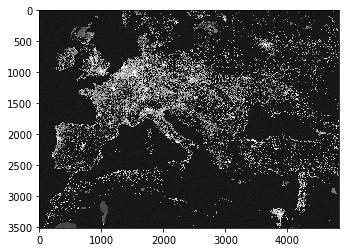

In [3]:

img_P = Image.open('/home/qurunlu/Documents/ELU501/moi/challenge_3/population-density-map.bmp')
plt.imshow(img_P)
width1=img_P.size[0]
heigth1=img_P.size[1]
print(width1)
print(heigth1)
colors1 = img_P.getcolors(width1*heigth1)
colors1
print('Nb of different colors: %d' % len(colors1))

4830
3510
Nb of different colors: 16567


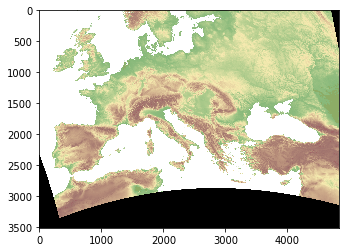

In [4]:
img_A = Image.open('/home/qurunlu/Documents/ELU501/moi/challenge_3/resultNB.bmp')
plt.imshow(img_A)
width=img_A.size[0]
heigth=img_A.size[1]
print(width)
print(heigth)
colors = img_A.getcolors(width*heigth)
colors
print('Nb of different colors: %d' % len(colors))

In [5]:
#p=plt.imshow(img)
#plt.colorbar(img)

In [6]:
#img_src = img.convert('RGBA')
#plt.imshow(img_src)
#src_strlist = img_src.load()
#data = src_strlist[100, 100]

### print the RGB values for each pixel

In [7]:
by_color = defaultdict(int) #return a dic {(r,g,b):values}
for pixel in img_A.getdata():
    by_color[pixel] += 1

In [8]:
all_colors=by_color.keys() #get the key of the dic;

colorlist = list() #return [(r,g,b)....]
for i in all_colors:
    colorlist.append(i)
#print(colorlist)


### convert rgb(0,255) to rgb(0,1)

In [9]:
convert = list()
for i in colorlist:
    t=list()
    for c in i:
        color_normalization=c/255
        #color=round(color_normalization,2)
        if(len(t)<=3):
            t.append(color_normalization)
    if(len(t)==3):
        n=tuple(t)
        convert.append(n)
#print(convert)
print(len(convert))

16567


In [11]:
import seaborn as sns
mycolorpoint_original=[[1,1,1],#[1/255,186/255,253/255],
              [141/255,172/255,102/255],
              [145/255,175/255,119/255],
              [161/255,195/255,134/255],
              [198/255,213/255,145/255],
              [213/255,221/255,161/255],
              [242/255,233/255,174/255],
              [233/255,211/255,164/255], 
              [203/255,161/255,136/255],
              [182/255,144/255,121/255],
              [173/255,128/255,122/255],
              [166/255,122/255,113/255],
              [159/255,101/255,100/255]]
#select some main rgb values(blue,green,light yellow,dark yellow,brown) to make a color palette


In [12]:
mycolorpoint=list()#the data is copied from matlab,which uses different format,too lazy too re-input it
mycolorpoint_original
for i in mycolorpoint_original:
    n=tuple(i)
    mycolorpoint.append(n)
print(mycolorpoint)

[(1, 1, 1), (0.5529411764705883, 0.6745098039215687, 0.4), (0.5686274509803921, 0.6862745098039216, 0.4666666666666667), (0.6313725490196078, 0.7647058823529411, 0.5254901960784314), (0.7764705882352941, 0.8352941176470589, 0.5686274509803921), (0.8352941176470589, 0.8666666666666667, 0.6313725490196078), (0.9490196078431372, 0.9137254901960784, 0.6823529411764706), (0.9137254901960784, 0.8274509803921568, 0.6431372549019608), (0.796078431372549, 0.6313725490196078, 0.5333333333333333), (0.7137254901960784, 0.5647058823529412, 0.4745098039215686), (0.6784313725490196, 0.5019607843137255, 0.47843137254901963), (0.6509803921568628, 0.47843137254901963, 0.44313725490196076), (0.6235294117647059, 0.396078431372549, 0.39215686274509803)]


### the color palette

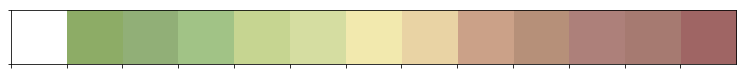

In [13]:
current_palette=sns.color_palette(mycolorpoint)
sns.palplot(current_palette)

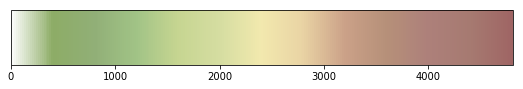

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(9, 1))
#fig.subplots_adjust(bottom=0.5)²

cmap = LinearSegmentedColormap.from_list(
         'gyb', mycolorpoint)
norm = mpl.colors.Normalize(vmin=0, vmax=4810)

colorbar1 = mpl.colorbar.ColorbarBase(ax, cmap,
                                norm=norm,
                                orientation='horizontal')

In [13]:
from pylab import *

cmaps = colorbar1.get_cmap()    # PiYG
rgb_colorbar=list()
for i in range(cmaps.N):
    rgb = cmaps(i)[:3] # will return rgba, we take only first 3 so we get rgb
    #print(matplotlib.colors.rgb2hex(rgb))
    rgb_colorbar.append(rgb)

    

In [14]:
#print(rgb_colorbar)
#print(len(rgb_colorbar))

In [21]:
gray = defaultdict(int)
for pixel in img_P.getdata():
    gray[pixel] += 1


In [ ]:
popularity=np.array(img_P)
print(popularity.shape)
#popularity #read the information of certain pixel

#plt.hist(gray.ravel())
#np.unique(gray)
popularity

In [ ]:
for y in range(heigth):
    for x in range(width):
        # p[y,x] is the coord (x,y), x the colum, and y the line
        # As an exemple, we search for the green and red pixels
        # p[y,x] is an array with 3 values
        # We test if there is a complete match between the 3 values 
        # from both arrays p[y,x] and np.array([0,255,0])
        # to detect green pixels
        if (popularity[y,x] == np.array([0,255,0])).all():
            print("Coordinates (x,y) of the green pixel: (%s,%s)" % (str(x),str(y)))
            # Coordinates (x,y) of the green pixel: (4426,2108)
        if (popularity[y,x] == np.array([255,0,0])).all():
            print("Coordinates (x,y) of the red pixel: (%s,%s)" % (str(x),str(y)))
            # Coordinates (x,y) of the red pixel: (669,1306)


Coordinates (x,y) of the red pixel: (669,1306)
Coordinates (x,y) of the green pixel: (4426,2108)


In [ ]:
def save_information_into_cell()

In [ ]:
#create a matrix to save the information for each cell
popularity_information=np.zeros((322, 234))

def current_popularity_information():
    for i in popularity_information:
        for j in popularity_information:
            if()
            popularity_information[i][j]
            

In [ ]:
from PIL import Image
import numpy as np
im = Image.open(input_filename)

# This modules gives useful informations
width=im.size[0]
heigth=im.size[1]
colors = im.getcolors(width*heigth)
print('Nb of different colors: %d' % len(colors))
# To plot an histogram
from matplotlib import pyplot as plt
def hexencode(rgb):
    r=rgb[0]
    g=rgb[1]
    b=rgb[2]
    return '#%02x%02x%02x' % (r,g,b)

for idx, c in enumerate(colors):
    plt.bar(idx, c[0], color=hexencode(c[1]))

plt.show()
# We have 32 different colors in this image
# We can see that we have "only" 91189 black pixels able to stop zombies 
# but we have a large majority of dark ones slowing their progression

# With the image im, let's generate a numpy array to manipulate pixels
p = np.array(im) 

print(p.shape)
# a result (3510, 4830, 3) means (rows, columns, color channels)
# where 3510 is the height and 4830 the width

# to get the Red value of pixel on row 3 and column 59
p[3,59][0]

# How to get the coordinates of the green and red pixels where 
# (0,0) is top-left and (width-1, height-1) is bottom-right
# In numpy array, notice that the first dimension is the height, 
# and the second dimension is the width. That is because, for a numpy array, 
# the first axis represents rows (our classical coord y), 
# and the second represents columns (our classical x).

# First method
# Here is a double loop (careful, O(n²) complexity) to parse the pixels from
# (0,0) top-left and (heigth-1, width-1) is bottom-right
for y in range(heigth):
    for x in range(width):
        # p[y,x] is the coord (x,y), x the colum, and y the line
        # As an exemple, we search for the green and red pixels
        # p[y,x] is an array with 3 values
        # We test if there is a complete match between the 3 values 
        # from both arrays p[y,x] and np.array([0,255,0])
        # to detect green pixels
        if (p[y,x] == np.array([0,255,0])).all():
            print("Coordinates (x,y) of the green pixel: (%s,%s)" % (str(x),str(y)))
            # Coordinates (x,y) of the green pixel: (4426,2108)
        if (p[y,x] == np.array([255,0,0])).all():
            print("Coordinates (x,y) of the red pixel: (%s,%s)" % (str(x),str(y)))
            # Coordinates (x,y) of the red pixel: (669,1306)

# Here is a more efficient method to get the location of the green and red pixels
mask = np.all(p == (0, 255, 0), axis=-1)
z = np.transpose(np.where(mask))
print("Coordinates (x,y) of the green pixel: (%d,%d)" % (z[0][1],z[0][0]))
mask = np.all(p == (255, 0, 0), axis=-1)
z = np.transpose(np.where(mask))
print("Coordinates (x,y) of the red pixel: (%d,%d)" % (z[0][1],z[0][0]))


# Now we have the source and the target positions of our zombies
# we could convert our RGB image into greyscale image to manipulate
# only 1 value for the color and deduce more easily the density of
# population
grayim = im.convert("L")
grayim.show()
colors = grayim.getcolors(width*heigth)
print('Nb of different colors: %d' % len(colors))
# With the image im, let's generate a numpy array to manipulate pixels
p = np.array(grayim) 
# plot the histogram. We still have a lot of dark colors. Just to check ;-)
plt.hist(p.ravel())

# from gray colors to density
density = p/255.0
# plot the histogram. We still have a lot of dark colors. Just to check ;-)
plt.hist(density.ravel())

# We can use the gray 2D array density to create our graph
# Gray colors density[y,x] range now from 0 (black) to 1 (white)
# density[0,0] is top-left pixel density
# and density[heigth-1,width-1] is bottom-right pixel